In [18]:

# # uncomment to download necessary packages and restart kernal to run rest of notebook
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install yfinance
# %pip install pandas_ta
# %pip install scikit-learn
# %pip install xgboost
# %pip install seaborn
# %pip install torch
# %pip install torch "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.12"


In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
import time
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
import torch

In [20]:
stock_symbols = [
    "RIVN",  # Rivian Automotive
    "TSLA",  # Tesla
    "NIO",   # Nio Inc ADR
    "XPEV",  # Xpeng Inc ADR
    "EVGO",  # Evgo Inc
    "LI",    # Li Auto Inc ADR
    "INDI",  # Indie Semiconductor Inc Class A
    "CHPT",  # Chargepoint Holdings Inc Class A
    "LCID",  # Lucid Group Inc
    "LAZR"   # Luminar Technologies Inc Class A
]
train_raw = yf.download(stock_symbols, start='2024-01-01', end='2024-08-31')['Close']
train_length = len(train_raw)
test = yf.download(stock_symbols, start='2024-09-01', end='2024-09-30')['Close']
test_length = len(test)
train_test_raw = pd.concat([train_raw, test])
train_test_raw = train_test_raw.join(train_test_raw.pct_change(), rsuffix = '_pct_change').dropna().reset_index()
train_length += -1


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


In [21]:
def preprocess(data, freq):
    #scaler = StandardScaler()
    rft = np.fft.rfft(data)
    rft[freq:] = 0
    smooth = np.fft.irfft(rft, n=len(data)) 
    smooth[:2], smooth[-2:] = data.iloc[:2], data.iloc[-2:]
    #smooth = scaler.fit_transform(smooth.reshape(-1, 1))
    return smooth
def rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [22]:
%%time
from tsfm_public import TimeSeriesForecastingPipeline, TinyTimeMixerForPrediction
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision = 'main', num_input_channels=1
)
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column='Date',
    target_columns=['Target'],
    explode_forecasts=True,
    freq="B",
    id_columns=[],
)

pred_ttm_day_pct = {}
pred_ttm_week_pct = {}
for x in stock_symbols:
    pred_day = []
    pred_week = []
    for y in range(test_length):
        #freq = -1 means no smoothening
        cur_data = train_test_raw[['Date']].iloc[:train_length + y]
        cur_data['Target'] = preprocess(train_test_raw[f"{x}_pct_change"].iloc[:train_length + y], freq = -1)
        forecast = pipeline(cur_data)['Target_prediction'][0]
        pred_day.append((forecast + 1)*train_test_raw[x].iloc[train_length + y - 1])

        cur_data = train_test_raw[['Date']].iloc[:train_length + y - 5]
        cur_data['Target'] = preprocess(train_test_raw[f"{x}_pct_change"].iloc[:train_length + y - 5], freq = -1)
        forecast = pipeline(cur_data)['Target_prediction'][:5].to_numpy()
        pred_week.append(np.prod(forecast + 1)*train_test_raw[x].iloc[train_length + y - 5])
    pred_ttm_day_pct[x] = pred_day
    pred_ttm_week_pct[x] = pred_week
pred_ttm_day_pct['TSLA']

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


CPU times: total: 16.6 s
Wall time: 6.63 s


[215.96888099994487,
 209.26481710146243,
 220.33997199793015,
 232.71012409299854,
 203.59848903385034,
 216.75173691250944,
 228.10217090618215,
 229.02181557638625,
 230.5810962314872,
 230.68246361234614,
 225.4684178896067,
 227.9451039473695,
 227.24813041105475,
 246.92276991698577,
 236.38706318987533,
 251.39464891981333,
 254.5880432345886,
 257.58084955805737,
 253.84013185228355]

In [23]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error
def MASE(actual, predicted, roll, test_length):
    naive_forecast = actual[-test_length - roll: -roll]
    actual = actual[-test_length:]
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual, naive_forecast), mean_absolute_percentage_error(actual, predicted)

mase_ttm_day_pct = {}
mape_ttm_day_pct = {}
for x in stock_symbols:
    mase_ttm_day_pct[x], mape_ttm_day_pct[x] = MASE(train_test_raw[x], pred_ttm_day_pct[x], 1, test_length)
    print(f"{x}: {mase_ttm_day_pct[x]}")
np.mean(list(mase_ttm_day_pct.values()))

RIVN: 1.1479363215707228
TSLA: 1.1213603490405064
NIO: 1.1094092492061591
XPEV: 1.0834405643670895
EVGO: 1.0109713709526316
LI: 1.0889940486261287
INDI: 1.053652274341958
CHPT: 1.118407020265767
LCID: 1.1042467613335227
LAZR: 1.166594713759847


1.1005012673464332

In [24]:
mase_ttm_week_pct = {}
mape_ttm_week_pct = {}
for x in stock_symbols:
    mase_ttm_week_pct[x], mape_ttm_week_pct[x] = MASE(train_test_raw[x], pred_ttm_week_pct[x], 5, test_length)
    print(f"{x}: {mase_ttm_week_pct[x]}")
np.mean(list(mase_ttm_week_pct.values()))

RIVN: 1.0209508941506016
TSLA: 1.0963519778070816
NIO: 1.0262123464316397
XPEV: 0.9886643958968293
EVGO: 1.253951387040133
LI: 1.042149057365791
INDI: 1.0886647673569045
CHPT: 1.1529234470519414
LCID: 1.1422356054047293
LAZR: 1.1872907253741023


1.0999394603879755

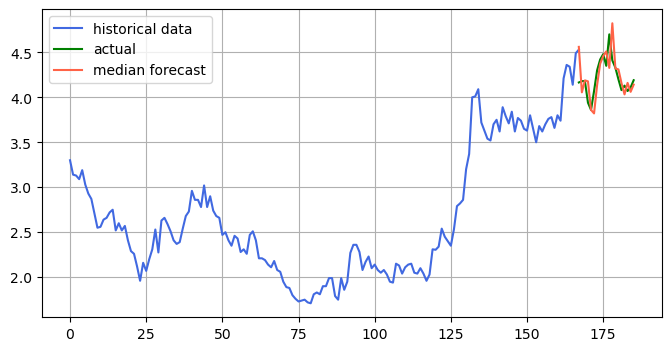

In [25]:
import matplotlib.pyplot as plt
forecast_index = range(train_length, train_length + test_length)
index = 'EVGO'
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_raw)),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_ttm_day_pct[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

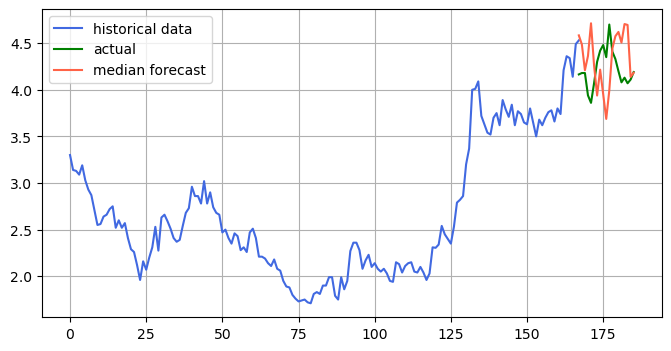

In [26]:
forecast_index = range(train_length, train_length + test_length)
index = 'EVGO'
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_raw)),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_ttm_week_pct[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

In [27]:
%%time
from tsfm_public import TimeSeriesForecastingPipeline, TinyTimeMixerForPrediction
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-v1", revision = 'main', num_input_channels=1
)
pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    timestamp_column='Date',
    target_columns=['Target'],
    explode_forecasts=True,
    freq="B",
    id_columns=[],
)

pred_ttm_day_true = {}
pred_ttm_week_true = {}
for x in stock_symbols:
    pred_day = []
    pred_week = []
    for y in range(test_length):
        #freq = -1 means no smoothening
        cur_data = train_test_raw[['Date']].iloc[:train_length+ y]
        cur_data['Target'] = preprocess(train_test_raw[x].iloc[:train_length + y], freq = -1)
        forecast = pipeline(cur_data)['Target_prediction'][0]
        pred_day.append(forecast)

        cur_data = train_test_raw[['Date']].iloc[:train_length+ y - 5]
        cur_data['Target'] = preprocess(train_test_raw[x].iloc[:train_length + y - 5], freq = -1)
        forecast = pipeline(cur_data)['Target_prediction'][4]
        pred_week.append(forecast)

    pred_ttm_day_true[x] = pred_day
    pred_ttm_week_true[x] = pred_week
pred_ttm_day_true['TSLA']

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


CPU times: total: 18.2 s
Wall time: 6.35 s


[220.43553161621094,
 219.40945434570312,
 227.4150390625,
 238.33595275878906,
 216.64715576171875,
 220.19830322265625,
 228.7060089111328,
 230.05072021484375,
 230.68545532226562,
 230.30081176757812,
 226.2882080078125,
 227.31427001953125,
 226.22503662109375,
 245.53390502929688,
 239.84375,
 253.71829223632812,
 258.8570556640625,
 261.549560546875,
 256.38031005859375]

In [28]:
mase_ttm_day_true = {}
mape_ttm_day_true = {}
for x in stock_symbols:
    mase_ttm_day_true[x], mape_ttm_day_true[x] = MASE(train_test_raw[x], pred_ttm_day_true[x], 1, test_length)
    print(f"{x}: {mase_ttm_day_true[x]}")
np.mean(list(mase_ttm_day_true.values()))

RIVN: 1.2359405076336811
TSLA: 0.8669339476486331
NIO: 1.0406607349950558
XPEV: 1.0461768681961325
EVGO: 1.0058220015535895
LI: 1.4890876156048132
INDI: 1.2305003316531806
CHPT: 1.3921327066062592
LCID: 1.0612688001370736
LAZR: 1.5431548768724135


1.1911678390900833

In [29]:
mase_ttm_week_true = {}
mape_ttm_week_true = {}
for x in stock_symbols:
    mase_ttm_week_true[x], mape_ttm_week_true[x] = MASE(train_test_raw[x], pred_ttm_week_true[x], 5, test_length)
    print(f"{x}: {mase_ttm_week_true[x]}")
np.mean(list(mase_ttm_week_true.values()))

RIVN: 1.0978808904918125
TSLA: 1.3135353333002047
NIO: 1.2147658782992807
XPEV: 1.1879233688665014
EVGO: 0.921254747054406
LI: 1.1201814752389179
INDI: 1.2248844928574623
CHPT: 1.0982283845280933
LCID: 0.6959435525957021
LAZR: 1.2430832370207527


1.1117681360253133

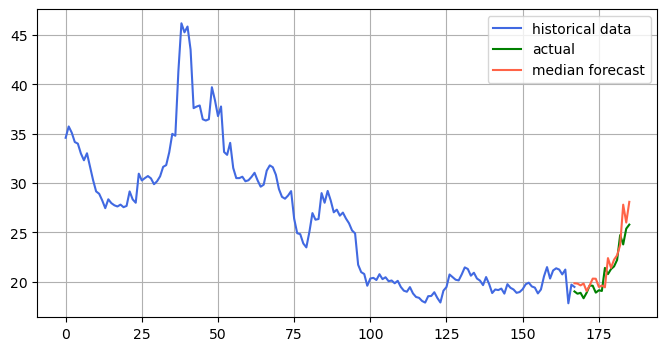

In [30]:
import matplotlib.pyplot as plt
forecast_index = range(train_length, train_length + test_length)
index = 'LI'
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_raw)),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_ttm_day_true[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()

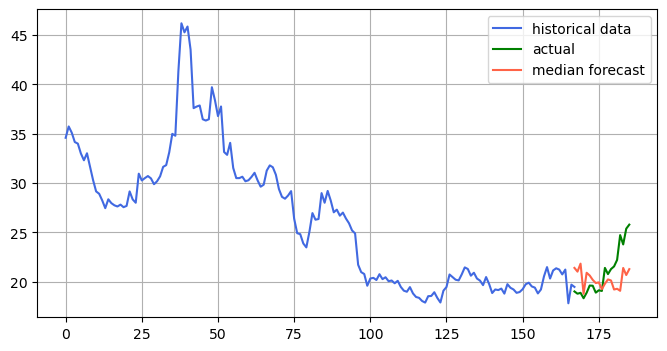

In [31]:
import matplotlib.pyplot as plt
forecast_index = range(train_length, train_length + test_length)
index = 'LI'
plt.figure(figsize=(8, 4))
plt.plot(range(len(train_raw)),train_raw[index].values, color="royalblue", label="historical data")
plt.plot(forecast_index, test[index].values, color="green", label="actual")
plt.plot(forecast_index, pred_ttm_week_true[index], color="tomato", label="median forecast")
plt.legend()
plt.grid()
plt.show()